### Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import keras.backend as K
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import quad
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from keras import backend
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### $\Phi$

[[1.00000000e+00 7.78190965e-04]
 [7.78190965e-04 1.00000000e+00]]


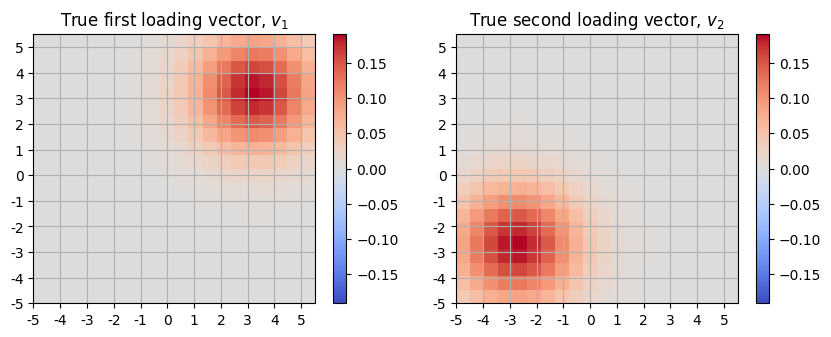

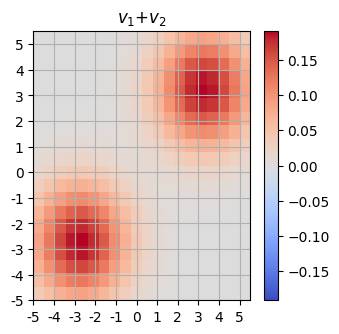

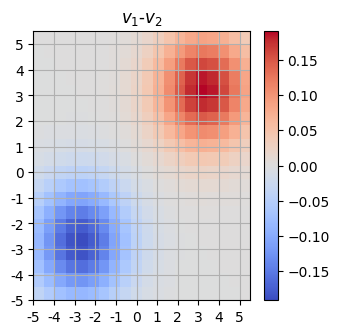

array([[1.00000000e+00, 7.78190965e-04],
       [7.78190965e-04, 1.00000000e+00]])

In [3]:
dims = 20
dimsquare = dims*dims
# 生成x和y的值
x = np.linspace(-5, 5, dims)
y = np.linspace(-5, 5, dims)
# 创建网格坐标
X, Y = np.meshgrid(x, y)
phi1 = np.exp(-(0.2*((X-3)**2)+(0.2*(Y-3)**2)))


phi2 = np.exp(-((0.2*(X+3)**2)+(0.2*(Y+3)**2)))

phi1 = phi1/np.sqrt(np.sum(phi1**2))
phi2 = phi2/np.sqrt(np.sum(phi2**2))




phit = pd.DataFrame([np.reshape(phi1,dimsquare),np.reshape(phi2,dimsquare)])
phit = np.array(phit)
maxx = np.max(phit)
minx = -np.max(phit)
print(phit.dot(np.transpose(phit)))
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
# Plot the first loading vector
ax[0].set_xticks(np.linspace(0, dims-1, 11))
ax[0].set_yticks(np.linspace(0, dims-1, 11))
ax[0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax[0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
img = ax[0].pcolormesh(np.reshape(phi1, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax[0].grid()
ax[0].set_title(r'True first loading vector, $v_1$')
fig.colorbar(img, ax=ax[0])

# Plot the second loading vector
ax[1].set_xticks(np.linspace(0, dims-1, 11))
ax[1].set_yticks(np.linspace(0, dims-1, 11))
ax[1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax[1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax[1].grid() # add grid
img = ax[1].pcolormesh(np.reshape(phi2, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax[1].set_title(r'True second loading vector, $v_2$')
fig.colorbar(img, ax=ax[1])


fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# Plot the first loading vector
ax.set_xticks(np.linspace(0, dims-1, 11))
ax.set_yticks(np.linspace(0, dims-1, 11))
ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
img = ax.pcolormesh(np.reshape(phi1+phi2, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax.grid()
ax.set_title(r'$v_1$+$v_2$')
fig.colorbar(img, ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# Plot the first loading vector
ax.set_xticks(np.linspace(0, dims-1, 11))
ax.set_yticks(np.linspace(0, dims-1, 11))
ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
img = ax.pcolormesh(np.reshape(phi1-phi2, (dims, dims)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
ax.grid()
ax.set_title(r'$v_1$-$v_2$')
fig.colorbar(img, ax=ax)
plt.show()



projection = np.reshape(phit[0,:],(dimsquare,1)).dot(np.reshape(phit[0,:],(1,dimsquare)))+np.reshape(phit[1,:],(dimsquare,1)).dot(np.reshape(phit[1,:],(1,dimsquare)))
'''
fig, ax = plt.subplots(1, 1, figsize=(3,3))
# Plot the first loading vector
ax.set_xticklabels([])
ax.set_yticklabels([])
img = ax.pcolormesh(np.reshape(projection, (dimsquare, dimsquare)), cmap='coolwarm', vmax=np.max(projection), vmin=np.min(projection))
ax.set_title('Projection matrix')
cax2 = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # x, y, width, height
fig.colorbar(img, cax=cax2)
plt.show()
'''
phit.dot(np.transpose(phit))

### 2D linear

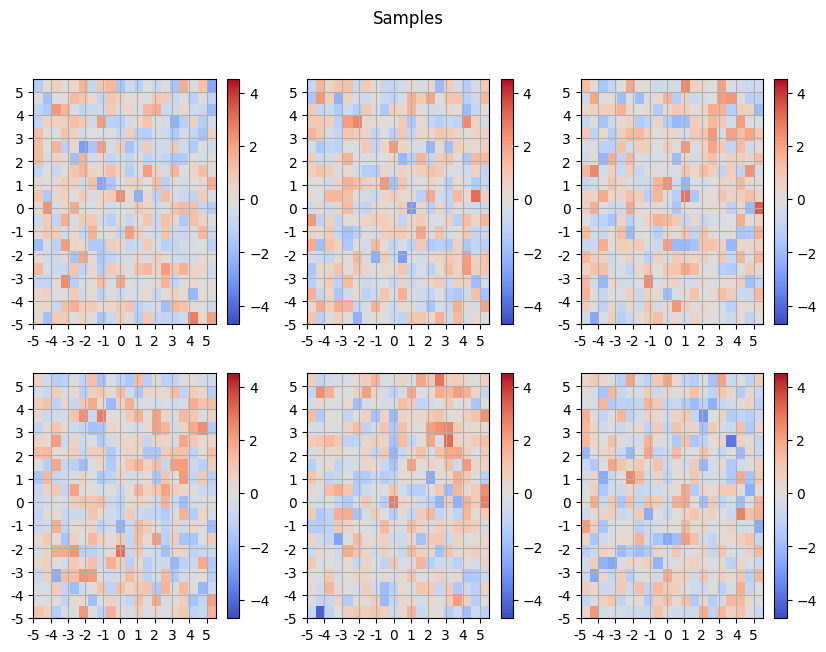

In [4]:
def poissondatagenerator(phit = phit, seeds = 10, means = [0,0], covmat = np.diag([9,4]), numsample = 500, dim2 = 2, num_plots=6):
    np.random.seed(seed=seeds+3)
    xdim = int(np.sqrt(phit.shape[1]))
    xi = np.random.multivariate_normal(means,covmat,numsample)

    dim = phit.shape[1]
    np.random.seed(seed=(seeds+3)*2)
    epsilon = np.reshape(np.random.normal(0,1,numsample*dim),(numsample,dim))
    z = xi.dot(phit)+epsilon
    '''
    np.random.seed(seed=(seeds+3)*2)
    z = np.random.poisson(np.exp(xi.dot(phit)))
    '''
    lambda_ = xi.dot(phit)

    np.random.seed(seed=(seeds+3)*3)
    #Y = lambda_
    Y = z
    Y2 = xi.dot(phit)
    if covmat[1,1] == 0:
      projection = np.reshape(phit[0,:],(dims,1)).dot(np.reshape(phit[0,:],(1,dims)))
    else:
      projection = np.reshape(phit[0,:],(dim,1)).dot(np.reshape(phit[0,:],(1,dim)))+np.reshape(phit[1,:],(dim,1)).dot(np.reshape(phit[1,:],(1,dim)))

    if dim2 == 2:
      fig, axs = plt.subplots(2, 3, figsize=(10, 7))
      for i in range(num_plots):
          row = i // 3
          col = i % 3
          axs[row, col].set_xticks(np.linspace(0, dims-1, 11))
          axs[row, col].set_yticks(np.linspace(0, dims-1, 11))
          axs[row, col].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axs[row, col].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axs[row, col].grid()
          img = axs[row, col].pcolormesh(np.reshape(Y[i], (xdim, xdim)), cmap='coolwarm', vmax = np.max(Y), vmin = np.min(Y))
          fig.colorbar(img, ax=axs[row, col])

      fig.suptitle('Samples')
      plt.show()


    if dim2 == 1:
      fig, axs = plt.subplots(2, 3, figsize=(10, 6))
      x_ticks = np.linspace(-5, 5, 9)  # 目标x轴刻度值

      for i in range(num_plots):
          row = i // 3
          col = i % 3
          axs[row, col].plot(Y[i])
          axs[row, col].set_xticks(np.linspace(0, dim-1, 9))  # 设置刻度位置
          axs[row, col].set_xticklabels([int(tick) for tick in x_ticks])  # 设置刻度标签
          #axs[row, col].set_yticks(np.linspace(-4, 4, 7))  # 设置刻度位置
          #axs[row, col].set_yticklabels([int(tick) for tick in np.linspace(-4, 4, 7)])  # 设置刻度标签

          axs[row, col].set_title(f'Sample {i+1}')
      fig.suptitle('Samples')
      plt.show()

    return Y, projection, lambda_


Y, projection, lambda_= poissondatagenerator()

### 2D models

In [5]:

def cae11(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', bias = False):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  #, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b
  inputs = keras.Input((xdim,xdim,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(inputs)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = bias, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(xdim*xdim,use_bias = bias, activation = activations,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)), kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
  x = layers.Reshape((xdim,xdim,1))(x)

  outputs = layers.Flatten()(x)
  cae1 = Model(inputs = inputs, outputs = outputs)
  cae1.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory1 = CAELossHistory()
  return cae1, CAEhistory1

def cae31(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', bias = False):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None

  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  inputs = keras.Input((xdim,xdim,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(inputs)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(x)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = bias, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(xdim*xdim,use_bias = bias, activation = activations,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)), kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
  x = layers.Reshape((xdim,xdim,1))(x)

  outputs = layers.Flatten()(x)
  cae3 = Model(inputs = inputs, outputs = outputs)
  cae3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory3 = CAELossHistory()
  return cae3, CAEhistory3

def cae51(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', bias = False):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  kernel_init = np.zeros((kernelshape0, kernelshape0))
  center = int(kernelshape0 / 2 - 0.5)
  kernel_init[center, center] = 1.0
  '''
  for i in range(kernelshape0):
    for j in range(kernelshape0):
      kernel_init[i, j]=np.exp(-((i-kernelshape0/2+0.5)**2+(j-kernelshape0/2+0.5)**2)/kernelshape0)
  kernel_init = kernel_init/np.sqrt(np.sum(kernel_init**2))
  '''
  b = tf.keras.initializers.Constant(kernel_init)
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  class UnitNormConstraint(tf.keras.constraints.Constraint):
      def __call__(self, w):
          # 計算卷積核的L2範數
          w_norm = tf.sqrt(tf.reduce_sum(tf.square(w)))+backend.epsilon()
          # 將卷積核除以L2範數，以確保總平方和為1
          return w / w_norm
  inputs = keras.Input((xdim,xdim,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(inputs)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(axis = [0,1]),kernel_initializer=b)(x)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = bias, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(xdim*xdim,use_bias = bias, activation = activations,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)), kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
  x = layers.Reshape((xdim,xdim,1))(x)

  outputs = layers.Flatten()(x)
  cae5 = Model(inputs = inputs, outputs = outputs)
  cae5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory5 = CAELossHistory()
  return cae5, CAEhistory5

def cae70(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0 = 'same', bias = False):
  if padding0 == 'same':
    a=tf.keras.initializers.Constant(pcloading)
  else:
    a = None
  class CAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)
  b = np.zeros((kernelshape0,kernelshape0))
  b[int(kernelshape0/2-0.5),int(kernelshape0/2-0.5)] = 1

  inputs = keras.Input((xdim,xdim,1))
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(inputs)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = padding0, activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Conv2D(1,kernel_size = kernelshape0,use_bias = bias, padding = 'same', activation = activations, kernel_constraint=tf.keras.constraints.UnitNorm(),kernel_initializer=tf.keras.initializers.Constant(b))(x)
  x = layers.Flatten()(x)
  code = layers.Dense(ncomp,name = 'code',use_bias = bias, kernel_regularizer=tf.keras.regularizers.L1(j),kernel_initializer=a)(x)
  x = layers.Dense(xdim*xdim,use_bias = bias, activation = activations,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)), kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code)
  x = layers.Reshape((xdim,xdim,1))(x)

  outputs = layers.Flatten()(x)
  cae7 = Model(inputs = inputs, outputs = outputs)
  cae7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  CAEhistory7 = CAELossHistory()
  return cae7, CAEhistory7

def sae02(xdim , activations , j ,ncomp, pcloading, bias = False):
  class SAELossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.l1_penalty_sum = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        l1_penalty = 0.0
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense) and layer.kernel_regularizer:
                if isinstance(layer.kernel_regularizer, tf.keras.regularizers.L1):
                    l1_penalty += np.sum(np.abs(layer.get_weights()[0]))
        self.l1_penalty_sum.append(l1_penalty)

  inputs1 = keras.Input((xdim,xdim,1))
  x1 = layers.Flatten()(inputs1)
  code1 = layers.Dense(ncomp,name = 'code',use_bias = bias, kernel_regularizer=tf.keras.regularizers.L1(j), activation = activations, kernel_initializer = tf.keras.initializers.Constant(pcloading))(x1)
  outputs2 = layers.Dense(xdim*xdim,name = 'reconstruct',use_bias = bias,kernel_initializer=tf.keras.initializers.Constant(np.transpose(pcloading)), kernel_constraint=tf.keras.constraints.UnitNorm(axis = 1))(code1)
  sae = Model(inputs = inputs1, outputs = outputs2)
  sae.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.mse, metrics = ['mse'])
  SAEhistory = SAELossHistory()
  return sae, SAEhistory


### 2D functions

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
import keras.backend as K
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd



#lambdas = [0]
lambdas = [0,0.0005,0.001,0.0015,0.0020,0.0025,0.0030,0.0035,0.0040,0.0045,0.0050,0.0055,0.0060,0.0065,0.0070,0.0075,0.0080,0.0085,0.0090,0.0095,0.01]
#lambdas = np.concatenate([np.repeat(0.0,7),np.repeat(0.05,7)])
size = [3,7,11]
ncomps = [2,3,4]
def spatialAE2D(Y = Y, ncomp = ncomps, activations = None, epoches = 1200, dx = 0.1, phit = phit, p = projection,lambda1 = lambdas,kernelshape = size, conti = 1, lambda_ = lambda_, padding0 = 'same'):
  xdim = int(np.sqrt(Y.shape[1]))
  dims = Y.shape[1]
  for i in range(Y.shape[1]):
     Y[:,i] = Y[:,i] - np.mean(Y[:,i])


  Y_train, Y_test,lambda_train,lambda_test = train_test_split(Y,lambda_, test_size = 300, random_state=42)
  Y_train, Y_valid = train_test_split(Y_train, test_size = 200, random_state=30)
  Y_train = Y_train*1.0
  Y_valid = Y_valid*1.0
  Y_test = Y_test*1.0
  lambda_train,lambda_test = lambda_train*1.0 ,lambda_test*1.0


  loss31 = []
  loss21 = []
  loss41 = []
  loss33 = []
  loss23 = []
  loss43 = []
  loss35 = []
  loss25 = []
  loss45 = []
  gridsearchcae1 = []
  gridsearchcae3 = []
  gridsearchcae5 = []

  ressaes = []
  gridsearchsae = []
  respcas = []
  resspcas = []
  respcavalids = []
  resspcavalids = []
  gridsearchspca = []

  fubae21 = []
  fubae31 = []
  fubae41 = []
  fubae23 = []
  fubae33 = []
  fubae43 = []
  fubae25 = []
  fubae35 = []
  fubae45 = []
  fubsaes = []
  fubspcas = []
  sfubindex = []
  cfub1index = []
  cfub3index = []
  cfub5index = []
  gridindex = 0
  for ncomp in ncomps:
    for kernelshape0 in kernelshape:
      lambdaindex = 0
      for j in lambda1:
        gridindex = gridindex + 1
        #PCA
        pca = PCA(n_components=ncomp)
        pca.fit(Y_train)
        pcloading = np.transpose(pca.components_)
        ppca = pcloading.dot(np.transpose(pcloading))
        #ppca = pcloading.dot(np.diag(pca.singular_values_)).dot(np.transpose(pcloading))
        pctrain = pca.fit_transform(Y_train)
        pctest = pca.transform(Y_test)
        pcvalid = pca.transform(Y_valid)
        reconpcatrain = pca.inverse_transform(pctrain)
        reconpcatest = pca.inverse_transform(pctest)
        reconpcavalid = pca.inverse_transform(pcvalid)
        respcatrain = np.mean(tf.keras.metrics.mean_squared_error(reconpcatrain,Y_train))
        respcatest = np.mean(tf.keras.metrics.mean_squared_error(reconpcatest,Y_test))
        respcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconpcavalid,Y_valid))
        respcas.append(respcatest)
        respcavalids.append(respcavalid)
        pcalhat = np.mean(reconpcatest,axis = 0)
        pcatestgof = np.mean(np.mean((reconpcatest-lambda_test)**2))


        #SPCA
        '''
        spca = SparsePCA(n_components=ncomp,alpha = j*25, max_iter = 50)
        spca.fit(Y_train)
        spcloading = np.transpose(spca.components_)
        spctrain = spca.fit_transform(Y_train)
        spctest = spca.transform(Y_test)
        spcvalid = spca.transform(Y_valid)
        spccov = pd.DataFrame.cov(pd.DataFrame(spctrain))
        reconspcatrain = spca.inverse_transform(spctrain)
        reconspcatest = spca.inverse_transform(spctest)
        reconspcavalid = spca.inverse_transform(spcvalid)
        pspca = spcloading.dot(np.transpose(spcloading).dot(spcloading)).dot(np.transpose(spcloading))
        #pspca = spcloading.dot(spccov).dot(np.transpose(spcloading))
        resspcatrain = np.mean(tf.keras.metrics.mean_squared_error(reconspcatrain,Y_train))
        resspcatest = np.mean(tf.keras.metrics.mean_squared_error(reconspcatest,Y_test))
        resspcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
        resspcas.append(resspcatest)
        gridsearchspca.append(resspcatest)
        resspcavalids.append(resspcavalid)
        spcalhat = np.mean(reconspcatest,axis = 0)
        spcatestgof = np.mean(np.mean((reconspcatest-lambda_test)**2))
        #print('SPCA loading',np.transpose(spcloading).dot(spcloading))
        '''
        #CAE
        cae1, CAEhistory1 = cae11(xdim , kernelshape0 , activations , j ,ncomp, pcloading)
        cae3, CAEhistory3 = cae31(xdim , kernelshape0 , activations , j ,ncomp, pcloading)
        cae5, CAEhistory5 = cae51(xdim , kernelshape0 , activations , j ,ncomp, pcloading)
        #cae7, CAEhistory7 = cae71(xdim , kernelshape0 , activations , j ,ncomp, pcloading, padding0)
        sae, SAEhistory = sae02(xdim , activations , j ,ncomp, pcloading)
        early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=20)
        '''
        plt.plot(pcloading)
        plt.title(fr'$v_{{PCA,i}}$', fontsize = 20)
        plt.legend([r'$v_{{PCA,1}}$',r'$v_{{PCA,2}}$'],fontsize = 20)
        plt.show()
        '''

        #weight loading
        lambdaindex = lambdaindex+1
        j2 = np.array(lambda1)
        if lambdaindex > 1:
          j3 = j2[lambdaindex-2]

          start_timeload = time.time()

          cae1.load_weights('./cae1%f.h5'%j3)
          #cae3.load_weights('./cae3%f.h5'%j3)
          #cae5.load_weights('./cae5%f.h5'%j3)
          #cae7.load_weights('./cae7%f.h5'%j3)
          sae.load_weights('./sae%f.h5'%j3)
          end_timeload = time.time()
          elapsed_timeload2 = start_timeload - end_timeload
          print(f"第{lambdaindex}個lambda LOAD model time: {elapsed_timeload2} 秒")

          '''
          #SAE plot
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()
          '''
          '''
          #SAEC plot
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''
          plt.plot(cae1.layers[3].weights[0].numpy())
          plt.title(fr'$W_{{2}}$, M=1, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{2,1}}$',r'$w_{{2,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
          plt.title(fr'$W_{{3}}$, M=1, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          '''


          start_timetrain1 = time.time()
          cae1.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory1,early_stopping])
          end_timetrain1 = time.time()
          elapsed_timetrain2 = start_timetrain1 - end_timetrain1
          print(f"第{lambdaindex}個lambda train 1st model time: {elapsed_timetrain2} 秒")
          conv1_weights = cae1.layers[1].get_weights()
          dense_weights = cae1.layers[3].get_weights()
          dense_weights2 = cae1.layers[4].get_weights()

          cae3.layers[1].set_weights(conv1_weights)
          cae3.layers[4].set_weights(dense_weights)
          cae3.layers[5].set_weights(dense_weights2)

          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            print(np.sum(cae1.layers[1].get_weights()[0]**2))

          '''
          '''
          plt.plot(cae1.layers[3].weights[0].numpy())
          plt.title(fr'$W_{{2}}$, M=1, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{2,1}}$',r'$w_{{2,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
          plt.title(fr'$W_{{3}}$, M=1, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          '''

          '''
            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''
          plt.plot(cae3.layers[4].get_weights()[0])
          plt.title(fr'$W_{{3}}$, M=2, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
          plt.title(fr'$W_{{4}}$, M=2, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{4}}$',r'$w_{{4}}$'],fontsize = 20)
          plt.show()
          '''
          start_timetrain3 = time.time()
          cae3.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory3,early_stopping])

          end_timetrain3 = time.time()
          elapsed_timetrain3 = start_timetrain3 - end_timetrain3
          print(f"第{lambdaindex}個lambda train 2nd model time: {elapsed_timetrain3} 秒")

          conv1_weights = cae3.layers[1].get_weights()
          conv1_weights2 = cae3.layers[2].get_weights()
          dense_weights = cae3.layers[4].get_weights()
          dense_weights2 = cae3.layers[5].get_weights()

          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''
          plt.plot(cae3.layers[4].get_weights()[0])
          plt.title(fr'$W_{{3}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
          plt.title(fr'$W_{{4}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{4,1}}$',r'$w_{{4,2}}$'],fontsize = 20)
          plt.show()
          '''



          cae5.layers[1].set_weights(conv1_weights)
          cae5.layers[2].set_weights(conv1_weights2)
          cae5.layers[6].set_weights(dense_weights)
          cae5.layers[7].set_weights(dense_weights2)


          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()


            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{4}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''

          plt.plot(cae5.layers[6].get_weights()[0])
          plt.title(fr'$W_{{5}}$, M=4, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{5,1}}$',r'$w_{{5,2}}$'],fontsize = 20)
          plt.show()

          plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
          plt.title(fr'$W_{{6}}$, M=4, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{6,1}}$',r'$w_{{6,2}}$'],fontsize = 20)
          plt.show()
          '''




          start_timetrain5 = time.time()
          cae5.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory5,early_stopping])
          end_timetrain5 = time.time()
          elapsed_timetrain5 = start_timetrain5 - end_timetrain5
          print(f"第{lambdaindex}個lambda train 3rd model time: {elapsed_timetrain5} 秒")
          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{m}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''
          plt.plot(cae5.layers[6].get_weights()[0])
          plt.title(fr'$W_{{5}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{5,1}}$',r'$w_{{5,2}}$'],fontsize = 20)
          plt.show()

          plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
          plt.title(fr'$W_{{6}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{6,1}}$',r'$w_{{6,2}}$'],fontsize = 20)
          plt.show()
          '''

          '''

          #cae7.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0, batch_size = Y_train.shape[0],callbacks = [CAEhistory7],early_stopping)

          '''
          start_timetrain0 = time.time()
          sae.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [SAEhistory,early_stopping])
          end_timetrain0 = time.time()
          elapsed_timetrain0 = start_timetrain0 - end_timetrain0
          print(f"第{lambdaindex}個lambda train SAE model time: {elapsed_timetrain0} 秒")

          '''
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()
          '''


          start_timesave2 = time.time()

          checkpoint_path1 = './cae1%f.h5'%j
          checkpoint_path3 = './cae3%f.h5'%j
          checkpoint_path5 = './cae5%f.h5'%j
          #checkpoint_path7 = './cae7%f.h5'%j
          checkpoint_path2 = './sae%f.h5'%j
          cae1.save_weights(checkpoint_path1)
          #cae3.save_weights(checkpoint_path3)
          #cae5.save_weights(checkpoint_path5)
          #cae7.save_weights(checkpoint_path7)
          sae.save_weights(checkpoint_path2)
          end_timesave2 = time.time()
          elapsed_timesave2 = start_timesave2 - end_timesave2
          print(f"第{lambdaindex}個lambda save model time: {elapsed_timesave2} 秒")

          '''
          cae_reconstruct1 = cae1.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct1test = cae1.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct1valid = cae1.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct3 = cae3.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct3test = cae3.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct3valid = cae3.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct5 = cae5.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct5test = cae5.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct5valid = cae5.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct7 = cae7.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7test = cae7.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7valid = cae7.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,1)), verbose = 0)

          sae_reconstruct = sae.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          sae_reconstructtest = sae.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          sae_reconstructvalid = sae.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)
          '''

        else:
          '''
          #SAE plot
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (Before training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()

          '''
          '''
          #SAEC plot
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''
          plt.plot(cae1.layers[3].weights[0].numpy())
          plt.title(fr'$W_{{2}}$, M=1, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{2,1}}$',r'$w_{{2,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
          plt.title(fr'$W_{{3}}$, M=1, $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          '''


          start_timetrain1 = time.time()
          cae1.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory1,early_stopping])
          end_timetrain1 = time.time()
          elapsed_timetrain2 = start_timetrain1 - end_timetrain1
          print(f"第{lambdaindex}個lambda train 1st model time: {elapsed_timetrain2} 秒")

          conv1_weights = cae1.layers[1].get_weights()
          dense_weights = cae1.layers[3].get_weights()
          dense_weights2 = cae1.layers[4].get_weights()

          cae3.layers[1].set_weights(conv1_weights)
          cae3.layers[4].set_weights(dense_weights)
          cae3.layers[5].set_weights(dense_weights2)
          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae1.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=1, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.legend([r'$C_{1,1}$'],fontsize = 20)
            plt.colorbar()
            plt.show()

            print(np.sum(cae1.layers[1].get_weights()[0]**2))
          '''
          '''
          plt.plot(cae1.layers[3].weights[0].numpy())
          plt.title(fr'$W_{{2}}$, M=1, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{2,1}}$',r'$w_{{2,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae1.layers[4].weights[0].numpy()))
          plt.title(fr'$W_{{3}}$, M=1, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          '''
          '''
            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()


          '''
          '''
          plt.plot(cae3.layers[4].get_weights()[0])
          plt.title(fr'$W_{{3}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
          plt.title(fr'$W_{{4}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{4}}$',r'$w_{{4}}$'],fontsize = 20)
          plt.show()
          '''


          start_timetrain3 = time.time()
          cae3.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory3,early_stopping])

          end_timetrain3 = time.time()
          elapsed_timetrain3 = start_timetrain3 - end_timetrain3
          print(f"第{lambdaindex}個lambda train 2nd model time: {elapsed_timetrain3} 秒")

          conv1_weights = cae3.layers[1].get_weights()
          conv1_weights2 = cae3.layers[2].get_weights()
          dense_weights = cae3.layers[4].get_weights()
          dense_weights2 = cae3.layers[5].get_weights()

          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae3.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=2, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()



          '''
          '''
          plt.plot(cae3.layers[4].get_weights()[0])
          plt.title(fr'$W_{{3}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{3,1}}$',r'$w_{{3,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(cae3.layers[5].get_weights()[0]))
          plt.title(fr'$W_{{4}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{4,1}}$',r'$w_{{4,2}}$'],fontsize = 20)
          plt.show()
          '''



          cae5.layers[1].set_weights(conv1_weights)
          cae5.layers[2].set_weights(conv1_weights2)
          cae5.layers[6].set_weights(dense_weights)
          cae5.layers[7].set_weights(dense_weights2)

          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()


            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{4}}$, M=4, $\lambda = {j}$ (Before training)', fontsize = 20)
            plt.colorbar()
            plt.show()

          plt.plot(cae5.layers[6].get_weights()[0])
          plt.title(fr'$W_{{5}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{5,1}}$',r'$w_{{5,2}}$'],fontsize = 20)
          plt.show()

          plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
          plt.title(fr'$W_{{6}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$ (Before training)', fontsize = 20)
          plt.legend([r'$w_{{6,1}}$',r'$w_{{6,2}}$'],fontsize = 20)
          plt.show()
          '''

          start_timetrain5 = time.time()
          cae5.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [CAEhistory5,early_stopping])
          end_timetrain5 = time.time()
          elapsed_timetrain5 = start_timetrain5 - end_timetrain5
          print(f"第{lambdaindex}個lambda train 3rd model time: {elapsed_timetrain5} 秒")
          '''
          if j in [np.round(np.linspace(0, 1, 11)/10,4)[0], np.round(np.linspace(0, 1, 11)/10,4)[6], np.round(np.linspace(0, 1, 11)/10,4)[10]]:
            plt.imshow(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[1].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{1}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[2].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{2}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()

            plt.imshow(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[3].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{3}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()


            plt.imshow(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0)),vmax= 1, vmin= -1, cmap='coolwarm')
            for x in range(kernelshape0):
              for y in range(kernelshape0):
                plt.text(y, x, f'{float(np.reshape(cae5.layers[4].get_weights()[0],(kernelshape0,kernelshape0))[x, y]):.3f}', ha='center', va='center', color='black')
            plt.title(fr'$C_{{4}}$, M=4, $\lambda = {j}$ (After training)', fontsize = 20)
            plt.colorbar()
            plt.show()
          '''
          '''
          plt.plot(cae5.layers[6].get_weights()[0])
          plt.title(fr'$W_{{5}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{5,1}}$',r'$w_{{5,2}}$'],fontsize = 20)
          plt.show()

          plt.plot(np.transpose(cae5.layers[7].get_weights()[0]))
          plt.title(fr'$W_{{6}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}} = {j}$', fontsize = 20)
          plt.legend([r'$w_{{6,1}}$',r'$w_{{6,2}}$'],fontsize = 20)
          plt.show()
          '''

          #cae7.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0, batch_size = Y_train.shape[0],callbacks = [CAEhistory7],early_stopping)


          start_timetrain0 = time.time()
          sae.fit(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)),Y_train, epochs = epoches, verbose = 0,callbacks = [SAEhistory,early_stopping])
          end_timetrain0 = time.time()
          elapsed_timetrain0 = start_timetrain0 - end_timetrain0
          print(f"第{lambdaindex}個lambda train SAE model time: {elapsed_timetrain0} 秒")

          '''
          plt.plot(sae.layers[2].get_weights()[0])
          plt.title(fr'$v_{{SE,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SE,1}}$',r'$v_{{SE,2}}$'],fontsize = 20)
          plt.show()
          plt.plot(np.transpose(sae.layers[3].get_weights()[0]))
          plt.title(fr'$v_{{SD,i}}$, M=1, $\lambda = {j/10}$ (After training)', fontsize = 20)
          plt.legend([r'$v_{{SD,1}}$',r'$v_{{SD,2}}$'],fontsize = 20)
          plt.show()
          '''


          start_timesave1 = time.time()

          checkpoint_path1 = './cae1%f.h5'%j
          checkpoint_path3 = './cae3%f.h5'%j
          checkpoint_path5 = './cae5%f.h5'%j
          #checkpoint_path7 = './cae7%f.h5'%j
          checkpoint_path2 = './sae%f.h5'%j
          cae1.save_weights(checkpoint_path1)
          #cae3.save_weights(checkpoint_path3)
          #cae5.save_weights(checkpoint_path5)
          #cae7.save_weights(checkpoint_path7)
          sae.save_weights(checkpoint_path2)

          end_timesave1 = time.time()
          elapsed_timesave1 = start_timesave1 - end_timesave1
          print(f"第一個lambda save model time: {elapsed_timesave1} 秒")
          '''

          cae_reconstruct1 = cae1.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct1test = cae1.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct1valid = cae1.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct3 = cae3.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct3test = cae3.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct3valid = cae3.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct5 = cae5.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct5test = cae5.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          cae_reconstruct5valid = cae5.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)

          cae_reconstruct7 = cae7.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7test = cae7.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,1)), verbose = 0)
          cae_reconstruct7valid = cae7.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,1)), verbose = 0)

          sae_reconstruct = sae.predict(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)), verbose = 0)
          sae_reconstructtest = sae.predict(np.reshape(Y_test,(Y_test.shape[0],xdim,xdim)), verbose = 0)
          sae_reconstructvalid = sae.predict(np.reshape(Y_valid,(Y_valid.shape[0],xdim,xdim)), verbose = 0)
          '''
        cae_get_code_layer_output1 = K.function([cae1.layers[0].input],[cae1.layers[3].output])
        cae_get_code_layer_output3 = K.function([cae3.layers[0].input],[cae3.layers[4].output])
        cae_get_code_layer_output5 = K.function([cae5.layers[0].input],[cae5.layers[6].output])
        #cae_get_code_layer_output7 = K.function([cae7.layers[0].input],[cae7.layers[9].output])
        sae_get_code_layer_output = K.function([sae.layers[0].input],[sae.layers[2].output])
        caecode1 = cae_get_code_layer_output1(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
        caecode3 = cae_get_code_layer_output3(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
        caecode5 = cae_get_code_layer_output5(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
        #caecode7 = cae_get_code_layer_output7(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
        saecode = sae_get_code_layer_output(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim,1)))[0]
        if activations == 'linear':
          print('using',activations,'estimating the loadings')
          #CAE estimation
          eaephi1 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode1)
          eaephi3 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode3)
          eaephi5 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode5)
          #eaephi7 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode7)
          saephi = sae.layers[2].weights[0].numpy()
        else:
          start_timeest = time.time()
          print('using',activations,'estimating the loadings')
          layer_output = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
          layer_output1 = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

          layer_output2 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
          layer_output3 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

          layer_output4 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
          layer_output5 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

          layer_output6 = sae_get_code_layer_output(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
          layer_output7 = sae_get_code_layer_output(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]
          end_timeest = time.time()
          elapsed_timeest = start_timeest - end_timeest
          print(f"{lambdaindex} estimation time: {elapsed_timeest} 秒")
          #layer_output8 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
          #layer_output9 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

          #gradient = layer_output
          eaephi1 = (layer_output-layer_output1)/dx
          eaephi3 = (layer_output2-layer_output3)/dx
          eaephi5 = (layer_output4-layer_output5)/dx
          saephi = (layer_output6-layer_output7)/dx

        for i in range(ncomp):
          eaephi1[:,i] = eaephi1[:,i]/np.sqrt(np.sum(eaephi1[:,i]**2))
          eaephi3[:,i] = eaephi3[:,i]/np.sqrt(np.sum(eaephi3[:,i]**2))
          eaephi5[:,i] = eaephi5[:,i]/np.sqrt(np.sum(eaephi5[:,i]**2))
          #eaephi7[:,i] = eaephi7[:,i]/np.sqrt(np.sum(eaephi7[:,i]**2))
          saephi[:,i] = saephi[:,i] /np.sqrt(np.sum(saephi[:,i]**2))

        cae_reconstruct1 = Y_train.dot(eaephi1).dot(np.transpose(eaephi1))
        cae_reconstruct1test = Y_test.dot(eaephi1).dot(np.transpose(eaephi1))
        cae_reconstruct1valid = Y_valid.dot(eaephi1).dot(np.transpose(eaephi1))

        cae_reconstruct3 = Y_train.dot(eaephi3).dot(np.transpose(eaephi3))
        cae_reconstruct3test = Y_test.dot(eaephi3).dot(np.transpose(eaephi3))
        cae_reconstruct3valid = Y_valid.dot(eaephi3).dot(np.transpose(eaephi3))

        cae_reconstruct5 = Y_train.dot(eaephi5).dot(np.transpose(eaephi5))
        cae_reconstruct5test = Y_test.dot(eaephi5).dot(np.transpose(eaephi5))
        cae_reconstruct5valid = Y_valid.dot(eaephi5).dot(np.transpose(eaephi5))

        sae_reconstruct = Y_train.dot(saephi).dot(np.transpose(saephi))
        sae_reconstructtest = Y_test.dot(saephi).dot(np.transpose(saephi))
        sae_reconstructvalid = Y_valid.dot(saephi).dot(np.transpose(saephi))

        #Loss value calculating
        #caeres1 = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1,Y_train))
        #caeres3 = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3,Y_train))
        #caeres5 = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5,Y_train))
        saeres = np.mean(tf.keras.metrics.mean_squared_error(sae_reconstruct,Y_train))
        caeres1test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1test,Y_test))
        caeres3test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3test,Y_test))
        caeres5test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5test,Y_test))
        #caeres7test = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct7test,Y_test))
        saerestest = np.mean(tf.keras.metrics.mean_squared_error(sae_reconstructtest,Y_test))
        caeres1valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct1valid,Y_valid))
        caeres3valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct3valid,Y_valid))
        caeres5valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct5valid,Y_valid))
        #caeres7valid = np.mean(tf.keras.metrics.mean_squared_error(cae_reconstruct7valid,Y_valid))
        saeresvalid = np.mean(tf.keras.metrics.mean_squared_error(sae_reconstructvalid,Y_valid))

        cae1lhat = np.mean(cae_reconstruct1test,axis = 0)
        cae1testgof = np.mean(np.mean((cae_reconstruct1test-lambda_test)**2))
        cae3lhat = np.mean(cae_reconstruct3test,axis = 0)
        cae3testgof = np.mean(np.mean((cae_reconstruct3test-lambda_test)**2))
        cae5lhat = np.mean(cae_reconstruct5test,axis = 0)
        cae5testgof = np.mean(np.mean((cae_reconstruct5test-lambda_test)**2))
        '''
        cae7lhat = np.mean(cae_reconstruct7test,axis = 0)
        cae7testgof = np.mean(np.mean((cae_reconstruct7test-lambda_test)**2))
        '''
        saelhat = np.mean(sae_reconstructtest,axis = 0)
        saetestgof = np.mean(np.mean((sae_reconstructtest-lambda_test)**2))

        #print(pcatestgof,spcatestgof,saetestgof,cae1testgof,cae3testgof,cae5testgof)
        #code

        #print(saecode.shape)
        ccode1mat = np.transpose(caecode1).dot(caecode1)
        ccode3mat = np.transpose(caecode3).dot(caecode3)
        ccode5mat = np.transpose(caecode5).dot(caecode5)
        #ccode7mat = np.transpose(caecode7).dot(caecode7)
        scodemat = np.transpose(saecode).dot(saecode)
        '''
        print('CAE1 cov',ccode1mat/Y_train.shape[0])
        print('CAE3 cov',ccode3mat/Y_train.shape[0])
        print('CAE5 cov',ccode5mat/Y_train.shape[0])
        print('SAE cov',scodemat/Y_train.shape[0])
        '''
        c1sortindex = np.argsort(np.diag(ccode1mat))[::-1]
        c3sortindex = np.argsort(np.diag(ccode3mat))[::-1]
        c5sortindex = np.argsort(np.diag(ccode5mat))[::-1]
        #c7sortindex = np.argsort(np.diag(ccode7mat))[::-1]
        ssortindex = np.argsort(np.diag(scodemat))[::-1]
        '''
        print(scodemat, ssortindex)
        print(ccode1mat, c1sortindex)
        print(ccode3mat, c3sortindex)
        print(ccode5mat, c5sortindex)
        '''
        '''
        caecov1 = pd.DataFrame.cov(pd.DataFrame(caecode1))
        caecov3 = pd.DataFrame.cov(pd.DataFrame(caecode3))
        caecov5 = pd.DataFrame.cov(pd.DataFrame(caecode5))
        saecov = pd.DataFrame.cov(pd.DataFrame(saecode))
        '''


        #daephi = np.linalg.inv(np.transpose(saecode).dot(saecode)).dot(np.transpose(saecode)).dot(sae_reconstruct)
        daephi = tf.transpose(sae.layers[3].weights[0].numpy())
        try:
          psae = saephi.dot(np.linalg.inv(np.transpose(saephi).dot(saephi))).dot(np.transpose(saephi))
          fubsae = np.sum((p-psae)**2)
        except:
          fubsae = 100
          print('SAE Singular matrix')
        try:
          pcae1 = eaephi1.dot(np.linalg.inv(np.transpose(eaephi1).dot(eaephi1))).dot(np.transpose(eaephi1))
          fubcae1 = np.sum((p-pcae1)**2)
        except:
          fubcae1 = 100
          print('CAE1 Singular matrix')
        try:
          pcae3 = eaephi3.dot(np.linalg.inv(np.transpose(eaephi3).dot(eaephi3))).dot(np.transpose(eaephi3))
          fubcae3 = np.sum((p-pcae3)**2)
        except:
          fubcae3 = 100
          print('CAE2 Singular matrix')
        try:
          pcae5 = eaephi5.dot(np.linalg.inv(np.transpose(eaephi5).dot(eaephi5))).dot(np.transpose(eaephi5))
          fubcae5 = np.sum((p-pcae5)**2)
        except:
          fubcae5 = 100
          print('CAE4 Singular matrix')
        '''
        try:
          pcae7 = eaephi7.dot(np.linalg.inv(np.transpose(eaephi7).dot(eaephi7))).dot(np.transpose(eaephi7))
          fubcae7 = np.sum((p-pcae7)**2)
        except:
          fubcae7 = 100
          print('CAE7 Singular matrix')
        '''






        '''
        pcae1 = eaephi1.dot(caecov1).dot(np.transpose(eaephi1))
        pcae3 = eaephi3.dot(caecov3).dot(np.transpose(eaephi3))
        pcae5 = eaephi5.dot(caecov5).dot(np.transpose(eaephi5))
        psae = saephi.dot(saecov).dot(np.transpose(saephi))
        '''
        fubpca = np.sum((p-ppca)**2)
        #fubspca = np.sum((p-pspca)**2)






        if gridindex == 1:
          pcafubindex = fubpca
          pcaresindex2 = respcatest
          pcaresindex = respcavalid
          pcabest = pca
          pcancomp = ncomp
          pcafubindex = fubpca
          pcalambdaindex = pcatestgof
          '''
          spcabest = spca
          spcalambdabest = j
          spcaresindex2 = resspcatest
          spcaresindex = resspcavalid
          spcancomp = ncomp
          spcafubindex = fubspca
          spcalambdaindex = spcatestgof
          '''


          if np.isnan(saeresvalid).any() == False:
            saebest = sae
            saelambdabest = j/10
            sresindex2 = saerestest
            sresindex = saeresvalid
            sncomp = ncomp
            sfubindex = fubsae
            slambdaindex = saetestgof
            s1 = 1
          elif np.isnan(saeresvalid).any()== True:
            s1 = 0
            print('SAE NONE')


          if np.isnan(caeres1valid).any() == False:
            cae1best = cae1
            lambda1best = j
            kernel1best = kernelshape0
            cres1index2 = caeres1test
            cres1index = caeres1valid
            cncomp1 = ncomp
            cfub1index = fubcae1
            cae1lambdaindex = cae1testgof
            c1 = 1
          elif np.isnan(caeres1valid).any()== True:
            c1 = 0
            print('CAE1 NONE')

          if np.isnan(caeres3valid).any() == False:
            cae3best = cae3
            lambda3best = j
            kernel3best = kernelshape0
            cres3index2 = caeres3test
            cres3index = caeres3valid
            cncomp3 = ncomp
            cfub3index = fubcae3
            cae3lambdaindex = cae3testgof
            c3 = 1
          elif np.isnan(caeres3valid).any()== True:
            c3 = 0
            print('CAE3 NONE')

          if np.isnan(caeres5valid).any() == False:
            cae5best = cae5
            lambda5best = j
            kernel5best = kernelshape0
            cres5index2 = caeres5test
            cres5index = caeres5valid
            cncomp5 = ncomp
            cfub5index = fubcae5
            cae5lambdaindex = cae5testgof
            c5 = 1
          elif np.isnan(caeres5valid).any()== True:
            c5 = 0
            print('CAE5 NONE')
          '''
          if np.isnan(caeres7valid).any() == False:
            cae7best = cae7
            lambda7best = j
            kernel7best = kernelshape0
            cres7index2 = caeres7test
            cres7index = caeres7valid
            cncomp7 = ncomp
            cfub7index = fubcae7
            cae7lambdaindex = cae7testgof
            c7 = 1
          elif np.isnan(caeres7valid).any()== True:
            c7 = 0
            print('CAE7 NONE')
          '''

        else:
          if respcavalid < pcaresindex:
            pcafubindex = fubpca
            pcaresindex2 = respcatest
            pcaresindex = respcavalid
            pcabest = pca
            pcancomp = ncomp
            pcalambdaindex = pcatestgof
          '''

          if resspcavalid < spcaresindex:
            spcabest = spca
            spcalambdabest = j
            spcaresindex2 = resspcatest
            spcaresindex = resspcavalid
            spcancomp = ncomp
            spcafubindex = fubspca
            spcalambdaindex = spcatestgof
          '''

          if np.isnan(saeresvalid).any() == False and np.isnan(saeresvalid).any() == False:
            if s1 == 0:
              saebest = sae
              saelambdabest = j/10
              sresindex2 = saerestest
              sresindex = saeresvalid
              #SAEhistoryindex = SAEhistory
              sncomp = ncomp
              sfubindex = fubsae
              slambdaindex = saetestgof
              print(f'SAE resindex = {sresindex}, lambda = {j/10}')
            else:
              if saeresvalid < sresindex:
                saebest = sae
                saelambdabest = j/10
                sresindex2 = saerestest
                sresindex = saeresvalid
                #SAEhistoryindex = SAEhistory
                sncomp = ncomp
                sfubindex = fubsae
                slambdaindex = saetestgof
                print(f'SAE resindex = {sresindex}, lambda = {j/10}')
                s1 = 1
          elif np.isnan(saeresvalid).any()== True or np.isnan(saeresvalid).any() == True:
            print('SAE NONE')

          if np.isnan(caeres1valid).any() == False and np.isnan(caeres1valid).any() == False:
            if c1 == 0:
              cae1best = cae1
              lambda1best = j
              kernel1best = kernelshape0
              cres1index2 = caeres1test
              cres1index = caeres1valid
              #CAEhistory1index = CAEhistory1
              cncomp1 = ncomp
              cfub1index = fubcae1
              cae1lambdaindex = cae1testgof
              print(f'CAE1 Fubindex = {cres1index}, lambda = {j}')
            else:
              if caeres1valid < cres1index:
                cae1best = cae1
                lambda1best = j
                kernel1best = kernelshape0
                cres1index2 = caeres1test
                cres1index = caeres1valid
                #CAEhistory1index = CAEhistory1
                cncomp1 = ncomp
                cfub1index = fubcae1
                cae1lambdaindex = cae1testgof
                print(f'CAE1 resindex = {cres1index}, lambda = {j}')
                s2 = 1
          elif np.isnan(caeres1valid).any()== True or np.isnan(caeres1valid).any() ==True:
            print('CAE1 NONE')


          if np.isnan(caeres3valid).any() == False and np.isnan(caeres3valid).any() == False:
            if c3 == 0:
              cae3best = cae3
              lambda3best = j
              kernel3best = kernelshape0
              cres3index2 = caeres3test
              cres3index = caeres3valid
              #CAEhistory3index = CAEhistory3
              cncomp3 = ncomp
              cfub3index = fubcae3
              cae3lambdaindex = cae3testgof
              print(f'CAE3 resindex = {cres3index}, lambda = {j}')
            else:
              if caeres3valid < cres3index:
                cae3best = cae3
                lambda3best = j
                kernel3best = kernelshape0
                cres3index2 = caeres3test
                cres3index = caeres3valid
                #CAEhistory3index = CAEhistory3
                cncomp3 = ncomp
                cfub3index = fubcae3
                cae3lambdaindex = cae3testgof
                print(f'CAE3 resindex = {cres3index}, lambda = {j}')
                c3 = 1
          elif np.isnan(caeres3valid).any()== True or np.isnan(caeres3valid).any() == True:
            print('CAE3 NONE')

          if np.isnan(caeres5valid).any() == False and np.isnan(caeres5valid).any() == False:
            if c5 == 0:
              cae5best = cae5
              lambda5best = j
              kernel5best = kernelshape0
              cres5index2 = caeres5test
              cres5index = caeres5valid
              #CAEhistory5index = CAEhistory5
              cncomp5 = ncomp
              cfub5index = fubcae5
              cae5lambdaindex = cae5testgof
              print(f'CAE5 resindex = {cres5index}, lambda = {j}')
            else:
              if caeres5valid < cres5index:
                cae5best = cae5
                lambda5best = j
                kernel5best = kernelshape0
                cres5index2 = caeres5test
                cres5index = caeres5valid
                #CAEhistory5index = CAEhistory5
                cncomp5 = ncomp
                cfub5index = fubcae5
                cae5lambdaindex = cae5testgof
                print(f'CAE5 resindex = {cres5index}, lambda = {j}')
                c5 = 1
          elif np.isnan(caeres5valid).any()== True or np.isnan(caeres5valid).any() == True:
            print('CAE5 NONE')
          '''
          if np.isnan(caeres7valid).any() == False and np.isnan(caeres7valid).any() == False:
            if c7 == 0:
              cae7best = cae7
              lambda7best = j
              kernel7best = kernelshape0
              cres7index2 = caeres7test
              cres7index = caeres7valid
              #CAEhistory5index = CAEhistory5
              cncomp7 = ncomp
              cfub7index = fubcae7
              cae7lambdaindex = cae7testgof
              print(f'CAE7 resindex = {cres7index}')
            else:
              if caeres7valid < cres7index:
                cae7best = cae7
                lambda7best = j
                kernel7best = kernelshape0
                cres7index2 = caeres7test
                cres7index = caeres7valid
                #CAEhistory5index = CAEhistory5
                cncomp7 = ncomp
                cfub7index = fubcae7
                cae7lambdaindex = cae7testgof
                print(f'CAE7 resindex = {cres7index}')
                c7 = 1
          elif np.isnan(caeres7valid).any()== True or np.isnan(caeres7valid).any() == True:
            print('CAE7 NONE')
          '''
        '''
        plt.plot(SAEhistory.losses,c = 'green')
        plt.axhline(respcatrain,c = 'red')
        #plt.axhline(resspcatrain,c = 'orange')

        plt.plot(CAEhistory1.losses,c = 'blue')
        plt.plot(CAEhistory3.losses,c = 'blue',linestyle = 'dashed')
        plt.plot(CAEhistory5.losses,c = 'blue',linestyle = 'dotted')
        #plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')

        plt.legend([fr'SAE, $\lambda$ = {j/10}','PCA',
                    fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'

                    ])
        plt.title(f'TRAINING LOSS')
        plt.xlabel('Epoch')
        plt.ylabel('TRAINING LOSS')
        plt.show()
        print('SAE LOSS',SAEhistory.losses[:5],SAEhistory.losses[-5:],len(SAEhistory.losses))
        print('CAE1 LOSS',CAEhistory1.losses[:5],CAEhistory1.losses[-5:],len(CAEhistory1.losses))
        print('CAE3 LOSS',CAEhistory3.losses[:5],CAEhistory3.losses[-5:],len(CAEhistory3.losses))
        print('CAE4 LOSS',CAEhistory5.losses[:5],CAEhistory5.losses[-5:],len(CAEhistory5.losses))




        plt.plot(CAEhistory1.l1_penalty_sum,c = 'blue')
        plt.plot(CAEhistory3.l1_penalty_sum,c = 'blue',linestyle = 'dashed')
        plt.plot(CAEhistory5.l1_penalty_sum,c = 'blue',linestyle = 'dotted')
        #plt.plot(CAEhistory7.losses,c = 'blue',linestyle = 'dashdot')

        plt.legend([     fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'

                    ])
        plt.title(f'L1 sum')
        plt.xlabel('Epoch')
        plt.ylabel('L1 sum')
        plt.show()
        '''


        '''
        plt.axhline(respcavalid,c = 'red')
        plt.axhline(resspcavalid,c = 'orange')
        plt.axhline(saeresvalid,c = 'green')
        plt.axhline(caeres1valid,c = 'blue')
        plt.axhline(caeres3valid,c = 'blue',linestyle = 'dashed')
        plt.axhline(caeres5valid,c = 'blue',linestyle = 'dotted')
        #plt.axhline(caeres7valid,c = 'blue',linestyle = 'dashdot')

        plt.legend(['PCA', fr'SPCA, $\lambda$ = {j}',
                    fr'SAE, $\lambda$ = {j/10}',
                    fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'])
        plt.title(r'Validation RSS')
        plt.xlabel('Epoch')
        plt.ylabel('Validation RSS')
        plt.show()
        print('SAE valid',saeresvalid)

        plt.axhline(pcatestgof,c = 'red')
        plt.axhline(spcatestgof,c = 'orange')
        plt.axhline(saetestgof,c = 'green')
        plt.axhline(cae1testgof,c = 'blue')
        plt.axhline(cae3testgof,c = 'blue',linestyle = 'dashed')
        plt.axhline(cae5testgof,c = 'blue',linestyle = 'dotted')
        #plt.axhline(cae7testgof,c = 'blue',linestyle = 'dashdot')

        plt.legend(['PCA', fr'SPCA, $\lambda$ = {j}',
                    fr'SAE, $\lambda$ = {j/10}',
                    fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {j}, filter = {kernelshape0}',
                    fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {j}, filter = {kernelshape0}'])
        plt.title(r'Testing $\lambda$ Prediction RSS')
        plt.xlabel('Epoch')
        plt.ylabel('Testing $\lambda$ Prediction RSS')
        plt.show()
        '''

        '''
        fig, axes = plt.subplots(nrows=ncomp, ncols=4, figsize=(14,6))
        vmax = max(max(phit[0]), max(phit[1]))
        vmin = min(min(phit[0]), min(phit[1]))
        for i in range(2):
          # True loading plot 1

          img = axes[i, 0].pcolormesh(np.reshape(phit[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          axes[i, 0].set_title(f'True')
          axes[i, 0].set_xticks(np.linspace(0, xdim-1, 11))
          axes[i, 0].set_yticks(np.linspace(0, xdim-1, 11))
          axes[i, 0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[i, 0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

          fig.colorbar(img, ax=axes[i, 0])


          # PCA loading plots
          if np.max(np.abs(pca.components_[i])) == -np.min(pca.components_[i]):
            pca.components_[i] = -pca.components_[i]
          img = axes[i, 1].pcolormesh(np.reshape(pca.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          axes[i, 1].set_title(f'PCA')
          axes[i, 1].set_xticks(np.linspace(0, xdim-1, 11))
          axes[i, 1].set_yticks(np.linspace(0, xdim-1, 11))
          axes[i, 1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[i, 1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

          fig.colorbar(img, ax=axes[i, 1])

          # SPCA loading plots
          if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
            saephi[:,i] = -saephi[:,i]
          img = axes[i, 2].pcolormesh(np.reshape(saephi[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          axes[i, 2].set_title(fr'SPCA , $\lambda$ = {j*10}')
          axes[i, 2].set_xticks(np.linspace(0, xdim-1, 11))
          axes[i, 2].set_yticks(np.linspace(0, xdim-1, 11))
          axes[i, 2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[i, 2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

          fig.colorbar(img, ax=axes[i, 2])


          # SAE loading plots
          if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
            saephi[:,i] = -saephi[:,i]
          img = axes[i, 3].pcolormesh(np.reshape(saephi[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          axes[i, 3].set_title(fr'SAE, $\lambda$ = {np.round(j/10,4)}')
          axes[i, 3].set_xticks(np.linspace(0, xdim-1, 11))
          axes[i, 3].set_yticks(np.linspace(0, xdim-1, 11))
          axes[i, 3].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
          axes[i, 3].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])



          fig.colorbar(img, ax=axes[i, 3])
        plt.tight_layout()
        plt.show()

        for i in range(2):
          # Plot for M=1
          fig, ax = plt.subplots(figsize=(5.5, 5))
          if np.max(np.abs(eaephi1[:, i])) == -np.min(eaephi1[:, i]):
              eaephi1[:, i] = -eaephi1[:, i]
          img = ax.pcolormesh(np.reshape(eaephi1[:, i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          ax.set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=1, d=({kernelshape0},{kernelshape0}), $\tau_{{3}}$={j}', fontsize=20)
          ax.set_xticks(np.linspace(0, xdim-1, 11))
          ax.set_yticks(np.linspace(0, xdim-1, 11))
          ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
          ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])

          fig.colorbar(img, ax=ax)
          plt.tight_layout()
          plt.show()

          # Plot for M=2
          fig, ax = plt.subplots(figsize=(5.5, 5))
          if np.max(np.abs(eaephi3[:, i])) == -np.min(eaephi3[:, i]):
              eaephi3[:, i] = -eaephi3[:, i]
          img = ax.pcolormesh(np.reshape(eaephi3[:, i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          ax.set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=2, d=({kernelshape0},{kernelshape0}), $\tau_{{3}}$={j}', fontsize=20)
          ax.set_xticks(np.linspace(0, xdim-1, 11))
          ax.set_yticks(np.linspace(0, xdim-1, 11))
          ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
          ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])

          fig.colorbar(img, ax=ax)
          plt.tight_layout()
          plt.show()

          # Plot for M=4
          fig, ax = plt.subplots(figsize=(5.5, 5))
          if np.max(np.abs(eaephi5[:, i])) == -np.min(eaephi5[:, i]):
              eaephi5[:, i] = -eaephi5[:, i]
          img = ax.pcolormesh(np.reshape(eaephi5[:, i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
          ax.set_title(fr'$\hat{{v}}^{{(CE)}}_{{{i+1}}}$, M=4, d=({kernelshape0},{kernelshape0}), $\tau_{{3}}$={j}', fontsize=20)
          ax.set_xticks(np.linspace(0, xdim-1, 11))
          ax.set_yticks(np.linspace(0, xdim-1, 11))
          ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
          ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])

          fig.colorbar(img, ax=ax)
          plt.tight_layout()
          plt.show()


        '''
        '''

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
        vmax =  np.max(p)
        vmin = np.min(p)

        # True projection matrix
        axes[0].pcolormesh(p, cmap='coolwarm', vmax=vmax, vmin=vmin)
        axes[0].set_title('True P')
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        fig.colorbar(axes[0].pcolormesh(p, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[0],shrink = 0.5)


        # PCA projection matrix
        axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=vmax, vmin=vmin)
        axes[1].set_title(r'PCA $\hat{P}$')
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        fig.colorbar(axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[1],shrink = 0.5)


        # SPCA projection matrix
        axes[2].pcolormesh(pspca, cmap='coolwarm', vmax=vmax, vmin=vmin)
        axes[2].set_title(r'SPCA $\hat{P}$')
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        fig.colorbar(axes[2].pcolormesh(pspca, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[2],shrink = 0.5)
        try:
          # SAE projection matrix
          axes[3].pcolormesh(psae, cmap='coolwarm', vmax=vmax, vmin=vmin)
          axes[3].set_title(r'SAE $\hat{P}$')
          axes[3].set_xticks([])
          axes[3].set_yticks([])
          fig.colorbar(axes[3].pcolormesh(psae, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[3],shrink = 0.5)
        except:
          print('No projection SAE')

        plt.show()

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3.5))
        vmax =  np.max(p)
        vmin = np.min(p)


        try:
          # CAE projection matrix
          axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=vmax, vmin=vmin)
          axes[0].set_title(r'CSAE w/ 1 Conv1D layer $\hat{P}$')
          axes[0].set_xticks([])
          axes[0].set_yticks([])
          fig.colorbar(axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[0],shrink = 0.5)
        except:
          print('No projection1')
        try:
          # CAE projection matrix
          axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=vmax, vmin=vmin)
          axes[1].set_title(r'CSAE w/ 2 Conv1D layers $\hat{P}$')
          axes[1].set_xticks([])
          axes[1].set_yticks([])
          fig.colorbar(axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[1],shrink = 0.5)
        except:
          print('NO Projection2')
        try:
          # CAE projection matrix
          axes[2].pcolormesh(pcae5, cmap='coolwarm', vmax=vmax, vmin=vmin)
          axes[2].set_title(r'CSAE w/ 4 Conv1D layers $\hat{P}$')
          axes[2].set_xticks([])
          axes[2].set_yticks([])
          fig.colorbar(axes[3].pcolormesh(pcae5, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[2],shrink = 0.5)
        except:
          print('NO Projection4')

        try:
          # CAE projection matrix
          axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=vmax, vmin=vmin)
          axes[3].set_title(r'CSAE w/ 7 Conv1D layers $\hat{P}$')
          axes[3].set_xticks([])
          axes[3].set_yticks([])
          fig.colorbar(axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[3],shrink = 0.5)
        except:
          print('NO Projection7')

        plt.show()


        '''
        '''
        print(f'PCA best Projection Fnorm = {pcafubindex}, Ncomp = {ncomp}')
        print(f'SPCA best Projection Fnorm = {spcafubindex}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE best Projection Fnorm = {sfubindex}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 best Projection Fnorm = {cfub1index}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 best Projection Fnorm = {cfub3index}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 best Projection Fnorm = {cfub5index}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        '''
        '''
        print(f'PCA Prediction RSS = {respcatest}, Ncomp = {ncomp}')
        print(f'SPCA Prediction RSS = {resspcatest}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE Prediction RSS = {saerestest}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 Prediction RSS = {caeres1test}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 Prediction RSS = {caeres3test}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 Prediction RSS = {caeres5test}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')

        print(f'PCA Validation RSS = {respcavalid}, Ncomp = {ncomp}')
        print(f'SPCA Validation RSS = {resspcavalid}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE Validation RSS = {saeresvalid}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 Validation RSS = {caeres1valid}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 Validation RSS = {caeres3valid}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 Validation RSS = {caeres5valid}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')


        print(f'PCA Projection Fnorm = {fubpca}, Ncomp = {ncomp}')
        print(f'SPCA Projection Fnorm = {fubspca}, lambda = {j*25}, Ncomp = {ncomp}')
        print(f'SAE Projection Fnorm = {fubsae}, lambda = {j/10}, Ncomp = {ncomp}')
        print(f'CAE 1 Projection Fnorm = {fubcae1}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 2 Projection Fnorm = {fubcae3}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')
        print(f'CAE 4 Projection Fnorm = {fubcae5}, lambda = {j}, filter = {kernelshape0}, Ncomp = {ncomp}')

        '''



        #print(f'MSE: PCA = {respcatest}, SPCA = {resspcatest}, SAE = {saerestest}, CAE1 = {caeres1test}, CAE2 = {caeres3test}, penalty lambda = {j}')
        #print(f'MSE of recon-PCA = {respca}, MSE of recon-AE = {resae}, MSE of recon-AE(by estimated loadings) = {resae2}, penalty lambda = {j}')
        #print(f'F-norm: PCA = {fubpca}, SPCA = {fubspca}, SAE = {fubsae}, CAE1 = {fubcae1}, CAE2 = {fubcae3}, penalty lambda = {j}')
        gridsearchcae1.append(caeres1test)
        gridsearchcae3.append(caeres3test)
        gridsearchcae5.append(caeres5test)
        gridsearchsae.append(saerestest)


        del cae1,cae3, cae5,sae
    resspcavalids = []
    '''
    for spcalambda in np.round(np.linspace(0, 30, 100),3):
      #SPCA
      spca = SparsePCA(n_components=ncomp,alpha = spcalambda)
      spca.fit(Y_train)
      spcvalid = spca.transform(Y_valid)
      reconspcavalid = spca.inverse_transform(spcvalid)
      resspcavalid = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
      resspcavalids.append(resspcavalid)


    bestspcalambda = np.round(np.linspace(0, 30, 100),3)[np.argmin(resspcavalids)]
    spcabest = SparsePCA(n_components=ncomp,alpha = bestspcalambda)
    spcabest.fit(Y_train)
    spcloading = np.transpose(spcabest.components_)
    spctrain = spcabest.fit_transform(Y_train)
    spctest = spcabest.transform(Y_test)
    spcvalid = spcabest.transform(Y_valid)
    spccov = pd.DataFrame.cov(pd.DataFrame(spctrain))
    reconspcatrain = spca.inverse_transform(spctrain)
    reconspcatest = spca.inverse_transform(spctest)
    reconspcavalid = spca.inverse_transform(spcvalid)
    pspca = spcloading.dot(np.transpose(spcloading).dot(spcloading)).dot(np.transpose(spcloading))
    spcaresindex2 = np.mean(tf.keras.metrics.mean_squared_error(reconspcatest,Y_test))
    spcaresindex = np.mean(tf.keras.metrics.mean_squared_error(reconspcavalid,Y_valid))
    spcalhat = np.mean(reconspcatest,axis = 0)
    spcatestgof = np.mean(np.mean((reconspcatest-lambda_test)**2))
    '''

    #code
    cae_get_code_layer_output1 = K.function([cae1best.layers[0].input],[cae1best.layers[3].output])
    cae_get_code_layer_output3 = K.function([cae3best.layers[0].input],[cae3best.layers[4].output])
    cae_get_code_layer_output5 = K.function([cae5best.layers[0].input],[cae5best.layers[6].output])
    #cae_get_code_layer_output7 = K.function([cae7best.layers[0].input],[cae7best.layers[9].output])
    sae_get_code_layer_output = K.function([saebest.layers[0].input],[saebest.layers[2].output])
    caecode1 = cae_get_code_layer_output1(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
    caecode3 = cae_get_code_layer_output3(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
    caecode5 = cae_get_code_layer_output5(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
    #caecode7 = cae_get_code_layer_output7(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]
    saecode = sae_get_code_layer_output(np.reshape(Y_train,(Y_train.shape[0],xdim,xdim)))[0]

    if activations == 'linear':
      #CAE estimation
      eaephi1 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode1)
      eaephi3 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode3)
      eaephi5 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode5)
      #eaephi7 = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(caecode7)
    else:
      layer_output = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
      layer_output1 = cae_get_code_layer_output1(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

      layer_output2 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
      layer_output3 = cae_get_code_layer_output3(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

      layer_output4 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
      layer_output5 = cae_get_code_layer_output5(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]

      #layer_output6 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)) + np.reshape(np.diag(np.repeat(dx,Y_train.shape[1])),(Y_train.shape[1],xdim,xdim)))[0]
      #layer_output7 = cae_get_code_layer_output7(np.reshape(np.tile(np.mean(Y_train,axis = 0),Y_train.shape[1]),(Y_train.shape[1],xdim,xdim)))[0]


      #gradient = layer_output
      eaephi1 = (layer_output-layer_output1)/dx
      eaephi3 = (layer_output2-layer_output3)/dx
      eaephi5 = (layer_output4-layer_output5)/dx
      #eaephi7 = (layer_output6-layer_output7)/dx


    for i in range(eaephi1.shape[1]):
      eaephi1[:,i] = eaephi1[:,i]/np.sqrt(np.sum(eaephi1[:,i]**2))
    for i in range(eaephi3.shape[1]):
      eaephi3[:,i] = eaephi3[:,i]/np.sqrt(np.sum(eaephi3[:,i]**2))

    for i in range(eaephi5.shape[1]):
      eaephi5[:,i] = eaephi5[:,i]/np.sqrt(np.sum(eaephi5[:,i]**2))



    #daephi = np.linalg.inv(np.transpose(saecode).dot(saecode)).dot(np.transpose(saecode)).dot(sae_reconstruct)
    daephi = tf.transpose(saebest.layers[3].weights[0].numpy())
    pcae1 = eaephi1.dot(np.linalg.inv(np.transpose(eaephi1).dot(eaephi1))).dot(np.transpose(eaephi1))
    pcae3 = eaephi3.dot(np.linalg.inv(np.transpose(eaephi3).dot(eaephi3))).dot(np.transpose(eaephi3))
    pcae5 = eaephi5.dot(np.linalg.inv(np.transpose(eaephi5).dot(eaephi5))).dot(np.transpose(eaephi5))
    #pcae7 = eaephi7.dot(np.linalg.inv(np.transpose(eaephi7).dot(eaephi7))).dot(np.transpose(eaephi7))

    saephi = np.linalg.inv(np.transpose(Y_train).dot(Y_train)).dot(np.transpose(Y_train)).dot(saecode)
    #saephi = saebest.layers[2].weights[0].numpy()

    for i in range(saephi.shape[1]):
      saephi[:,i] = saephi[:,i] /np.sqrt(np.sum(saephi[:,i]**2))



    psae = saephi.dot(np.linalg.inv(np.transpose(saephi).dot(saephi))).dot(np.transpose(saephi))



    #spcloadingbest = np.transpose(spcabest.components_)

    #pspcabest = spcloadingbest.dot(np.transpose(spcloadingbest).dot(spcloadingbest)).dot(np.transpose(spcloadingbest))
    pcloading = np.transpose(pcabest.components_)
    ppca = pcloading.dot(np.transpose(pcloading))
    fubpca = np.sum((p-ppca)**2)
    fubcae1 = np.sum((p-pcae1)**2)
    fubcae3 = np.sum((p-pcae3)**2)
    fubcae5 = np.sum((p-pcae5)**2)
    #fubcae7 = np.sum((p-pcae7)**2)
    #fubspca = np.sum((p-pspcabest)**2)
    fubsae = np.sum((p-psae)**2)


    plt.axhline(fubpca,c = 'red')
    #plt.axhline(fubspca,c = 'orange')
    plt.axhline(fubsae,c = 'green')
    plt.axhline(fubcae1,c = 'blue')
    plt.axhline(fubcae3,c = 'blue',linestyle = 'dashed')
    plt.axhline(fubcae5,c = 'blue',linestyle = 'dotted')
    #plt.axhline(fubcae7,c = 'blue',linestyle = 'dashdot')
    plt.legend(['PCA',
                fr'SAE, $\lambda$ = {saelambdabest}',
                fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {lambda1best}, filter = {kernel1best}',
                fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {lambda3best}, filter = {kernel3best}',
                fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {lambda5best}, filter = {kernel5best}'])
    plt.title(f'Grid Search Fnorm')
    plt.xlabel('Epoch')
    plt.ylabel('Fnorm')
    plt.show()


    plt.axhline(pcaresindex2,c = 'red')
    #plt.axhline(spcaresindex2,c = 'orange')
    plt.axhline(sresindex2,c = 'green')
    plt.axhline(cres1index2,c = 'blue')
    plt.axhline(cres3index2,c = 'blue',linestyle = 'dashed')
    plt.axhline(cres5index2,c = 'blue',linestyle = 'dotted')
    #plt.axhline(cres7index2,c = 'blue',linestyle = 'dashdot')
    plt.legend(['PCA',
                fr'SAE, $\lambda$ = {saelambdabest}',
                fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {lambda1best}, filter = {kernel1best}',
                fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {lambda3best}, filter = {kernel3best}',
                fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {lambda5best}, filter = {kernel5best}'])
    plt.title(f'Grid Search Testing MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Testing MSE')
    plt.show()
    '''
    plt.axhline(pcalambdaindex,c = 'red')
    plt.axhline(spcalambdaindex,c = 'orange')
    plt.axhline(slambdaindex,c = 'green')
    plt.axhline(cae1lambdaindex,c = 'blue')
    plt.axhline(cae3lambdaindex,c = 'blue',linestyle = 'dashed')
    plt.axhline(cae5lambdaindex,c = 'blue',linestyle = 'dotted')

    plt.legend(['PCA', fr'SPCA, $\lambda$ = {spcalambdabest}',
                fr'SAE, $\lambda$ = {saelambdabest}',
                fr'Sparse CAE w/ 1 conv1d, $\lambda$ = {lambda1best}, filter = {kernel1best}',
                fr'Sparse CAE w/ 2 conv1d, $\lambda$ = {lambda3best}, filter = {kernel3best}',
                fr'Sparse CAE w/ 4 conv1d, $\lambda$ = {lambda5best}, filter = {kernel5best}'
                ])
    plt.title(r'Grid Search $\lambda$ Prediction RSS')
    plt.xlabel('Epoch')
    plt.ylabel('$\lambda$ Prediction RSS')
    plt.show()

    '''
    fig, axes = plt.subplots(nrows=ncomp, ncols=4, figsize=(14,6))
    vmax = max(max(phit[0]), max(phit[1]))
    vmin = min(min(phit[0]), min(phit[1]))


    for i in range(2):
      # True loading plot 1

      img = axes[i, 0].pcolormesh(np.reshape(phit[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 0].set_title(f'True')
      axes[i, 0].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 0].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

      fig.colorbar(img, ax=axes[i, 0])


      # PCA loading plots
      if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
        pcabest.components_[i] = -pcabest.components_[i]
      img = axes[i, 1].pcolormesh(np.reshape(pcabest.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 1].set_title(f'PCA')
      axes[i, 1].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 1].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

      fig.colorbar(img, ax=axes[i, 1])

      # SPCA loading plots
      if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
        saephi[:,i] = -saephi[:,i]
      img = axes[i, 2].pcolormesh(np.reshape(saephi[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 2].set_title(fr'SPCA')
      axes[i, 2].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 2].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      fig.colorbar(img, ax=axes[i, 2])


      # SAE loading plots
      if np.max(np.abs(saephi[:,i])) == -np.min(saephi[:,i]):
        saephi[:,i] = -saephi[:,i]
      img = axes[i, 3].pcolormesh(np.reshape(saephi[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 3].set_title(fr'SAE')
      axes[i, 3].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 3].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 3].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 3].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])


      fig.colorbar(img, ax=axes[i, 3])
    plt.tight_layout()
    plt.show()


    fig, axes = plt.subplots(nrows=ncomp, ncols=3, figsize=(11.5,6))
    vmax = max(max(phit[0]), max(phit[1]))
    vmin = min(min(phit[0]), min(phit[1]))
    for i in range(2):
      # True loading plot 1


      # SCAE loading plots
      if np.max(np.abs(eaephi1[:,i])) == -np.min(eaephi1[:,i]):
        eaephi1[:,i] = -eaephi1[:,i]
      img = axes[i, 0].pcolormesh(np.reshape(eaephi1[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 0].set_title(fr'SAEC w/ 1 Conv2D layers')
      axes[i, 0].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 0].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 0].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 0].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

      fig.colorbar(img, ax=axes[i, 0])

      # SCAE loading plots
      if np.max(np.abs(eaephi3[:,i])) == -np.min(eaephi3[:,i]):
        eaephi3[:,i] = -eaephi3[:,i]
      img = axes[i, 1].pcolormesh(np.reshape(eaephi3[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 1].set_title(fr'SAEC w/ 2 Conv2D layers')
      axes[i, 1].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 1].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 1].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 1].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

      fig.colorbar(img, ax=axes[i, 1])

      # SCAE loading plots
      if np.max(np.abs(eaephi5[:,i])) == -np.min(eaephi5[:,i]):
        eaephi5[:,i] = -eaephi5[:,i]
      img = axes[i, 2].pcolormesh(np.reshape(eaephi5[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 2].set_title(fr'SAEC w/ 4 Conv2D layers')
      axes[i, 2].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 2].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 2].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 2].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

      fig.colorbar(img, ax=axes[i, 2])
      '''
      img = axes[i, 3].pcolormesh(np.reshape(eaephi7[:,i], (xdim, xdim)), cmap='coolwarm', vmax=np.max(phit), vmin=minx)
      axes[i, 3].set_title(fr'SAEC w/ 7 Conv2D layers')
      axes[i, 3].set_xticks(np.linspace(0, xdim-1, 11))
      axes[i, 3].set_yticks(np.linspace(0, xdim-1, 11))
      axes[i, 3].set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])
      axes[i, 3].set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11) ])

      fig.colorbar(img, ax=axes[i, 3])
      '''
    plt.tight_layout()
    plt.show()
    vmax = max(max(phit[0]), max(phit[1]))
    vmin = min(min(phit[0]), min(phit[1]))

    for i in range(ncomp):
        # True loading plot
        fig, ax = plt.subplots(figsize=(5, 5))
        img = ax.pcolormesh(np.reshape(phit[i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        ax.set_title(fr'$v_{{{i+1}}}$', fontsize=20)
        ax.set_xticks(np.linspace(0, xdim-1, 11))
        ax.set_yticks(np.linspace(0, xdim-1, 11))
        ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])

        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()

        # PCA loading plot
        fig, ax = plt.subplots(figsize=(5, 5))
        if np.max(np.abs(pcabest.components_[i])) == -np.min(pcabest.components_[i]):
            pcabest.components_[i] = -pcabest.components_[i]
        img = ax.pcolormesh(np.reshape(pcabest.components_[i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        ax.set_title(fr'PCA: $\hat{{v}}_{{{i+1}}}$', fontsize=20)
        ax.set_xticks(np.linspace(0, xdim-1, 11))
        ax.set_yticks(np.linspace(0, xdim-1, 11))
        ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()

        # SPCA loading plot
        fig, ax = plt.subplots(figsize=(5, 5))
        img = ax.pcolormesh(np.reshape(saephi[:,i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        ax.set_title(fr'SPCA: $\hat{{v}}^{{(s)}}_{{{i+1}}}$', fontsize=20)
        ax.set_xticks(np.linspace(0, xdim-1, 11))
        ax.set_yticks(np.linspace(0, xdim-1, 11))
        ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()

        # SAE loading plot
        fig, ax = plt.subplots(figsize=(5, 5))
        img = ax.pcolormesh(np.reshape(saephi[:,i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        ax.set_title(fr'SAE: $\hat{{v}}^{{(SE)}}_{{{i+1}}}$', fontsize=20)
        ax.set_xticks(np.linspace(0, xdim-1, 11))
        ax.set_yticks(np.linspace(0, xdim-1, 11))
        ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()

        # SCAE loading plot
        fig, ax = plt.subplots(figsize=(5, 5))
        if np.argmin([cres1index, cres3index, cres5index]) == 0:
            if np.max(np.abs(eaephi1[:, i])) == -np.min(eaephi1[:, i]):
                eaephi1[:, i] = -eaephi1[:, i]
            img = ax.pcolormesh(np.reshape(eaephi1[:, i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        elif np.argmin([cres1index, cres3index, cres5index]) == 1:
            if np.max(np.abs(eaephi3[:, i])) == -np.min(eaephi3[:, i]):
                eaephi3[:, i] = -eaephi3[:, i]
            img = ax.pcolormesh(np.reshape(eaephi3[:, i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        elif np.argmin([cres1index, cres3index, cres5index]) == 2:
            if np.max(np.abs(eaephi5[:, i])) == -np.min(eaephi5[:, i]):
                eaephi5[:, i] = -eaephi5[:, i]
            img = ax.pcolormesh(np.reshape(eaephi5[:, i], (xdim, xdim)), cmap='coolwarm', vmax=vmax, vmin=-np.max(phit))
        ax.set_title(fr'SAE-C: $\hat{{v}}^{{(CE)}}_{{{i+1}}}$', fontsize=20)
        ax.set_xticks(np.linspace(0, xdim-1, 11))
        ax.set_yticks(np.linspace(0, xdim-1, 11))
        ax.set_xticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        ax.set_yticklabels([int(tick) for tick in np.linspace(-5, 5, 11)])
        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()


    '''
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
    vmax =  np.max(p)
    vmin = np.min(p)

    # True projection matrix
    axes[0].pcolormesh(p, cmap='coolwarm', vmax=vmax, vmin=vmin)
    axes[0].set_title('True P')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.colorbar(axes[0].pcolormesh(p, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[0],shrink = 0.5)


    # PCA projection matrix
    axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=vmax, vmin=vmin)
    axes[1].set_title(r'PCA $\hat{P}$')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    fig.colorbar(axes[1].pcolormesh(ppca, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[1],shrink = 0.5)


    # SPCA projection matrix
    axes[2].pcolormesh(pspcabest, cmap='coolwarm', vmax=vmax, vmin=vmin)
    axes[2].set_title(r'SPCA $\hat{P}$')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    fig.colorbar(axes[2].pcolormesh(pspcabest, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[2],shrink = 0.5)
    try:
      # SAE projection matrix
      axes[3].pcolormesh(psae, cmap='coolwarm', vmax=vmax, vmin=vmin)
      axes[3].set_title(r'SAE $\hat{P}$')
      axes[3].set_xticks([])
      axes[3].set_yticks([])
      fig.colorbar(axes[3].pcolormesh(psae, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[3],shrink = 0.5)
    except:
      print('No projection SAE')

    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
    vmax =  np.max(p)
    vmin = np.min(p)


    try:
      # CAE projection matrix
      axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=vmax, vmin=vmin)
      axes[0].set_title(r'CSAE w/ 1 Conv1D layer $\hat{P}$')
      axes[0].set_xticks([])
      axes[0].set_yticks([])
      fig.colorbar(axes[0].pcolormesh(pcae1, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[0],shrink = 0.5)
    except:
      print('No projection1')
    try:
      # CAE projection matrix
      axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=vmax, vmin=vmin)
      axes[1].set_title(r'CSAE w/ 2 Conv1D layers $\hat{P}$')
      axes[1].set_xticks([])
      axes[1].set_yticks([])
      fig.colorbar(axes[1].pcolormesh(pcae3, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[1],shrink = 0.5)
    except:
      print('NO Projection2')
    try:
      # CAE projection matrix
      axes[2].pcolormesh(pcae5, cmap='coolwarm', vmax=vmax, vmin=vmin)
      axes[2].set_title(r'CSAE w/ 4 Conv1D layers $\hat{P}$')
      axes[2].set_xticks([])
      axes[2].set_yticks([])
      fig.colorbar(axes[2].pcolormesh(pcae5, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[2],shrink = 0.5)
    except:
      print('NO Projection4')

    try:
      # CAE projection matrix
      axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=vmax, vmin=vmin)
      axes[3].set_title(r'CSAE w/ 7 Conv1D layers $\hat{P}$')
      axes[3].set_xticks([])
      axes[3].set_yticks([])
      fig.colorbar(axes[3].pcolormesh(pcae7, cmap='coolwarm', vmax=vmax, vmin=vmin), ax=axes[3],shrink = 0.5)
    except:
      print('NO Projection7')
    plt.show()
    '''


    print(f'PCA Prediction RSS = {pcaresindex2}, Ncomp = {pcancomp}')
    #print(f'SPCA Prediction RSS = {spcaresindex2}, lambda = {bestspcalambda}, Ncomp = {spcancomp}')
    print(f'SAE Prediction RSS = {sresindex2}, lambda = {saelambdabest}, Ncomp = {sncomp}')
    print(f'CAE 1 Prediction RSS = {cres1index2}, lambda = {lambda1best}, filter = {kernel1best}, Ncomp = {cncomp1}')
    print(f'CAE 2 Prediction RSS = {cres3index2}, lambda = {lambda3best}, filter = {kernel3best}, Ncomp = {cncomp3}')
    print(f'CAE 4 Prediction RSS = {cres5index2}, lambda = {lambda5best}, filter = {kernel5best}, Ncomp = {cncomp5}')
    #print(f'CAE 7 Prediction RSS = {cres7index2}, lambda = {lambda7best}, filter = {kernel7best}, Ncomp = {cncomp7}')


    print(f'PCA Projection Fnorm = {pcafubindex}, Ncomp = {pcancomp}')
    #print(f'SPCA Projection Fnorm = {fubspca}, lambda = {spcalambdabest}, Ncomp = {spcancomp}')
    print(f'SAE Projection Fnorm = {fubsae}, lambda = {saelambdabest}, Ncomp = {sncomp}')
    print(f'CAE 1 Projection Fnorm = {fubcae1}, lambda = {lambda1best}, filter = {kernel1best}, Ncomp = {cncomp1}')
    print(f'CAE 2 Projection Fnorm = {fubcae3}, lambda = {lambda3best}, filter = {kernel3best}, Ncomp = {cncomp3}')
    print(f'CAE 4 Projection Fnorm = {fubcae5}, lambda = {lambda5best}, filter = {kernel5best}, Ncomp = {cncomp5}')
    #print(f'CAE 7 Projection Fnorm = {fubcae7}, lambda = {lambda7best}, filter = {kernel7best}, Ncomp = {cncomp7}')


    del cae1best, cae3best, cae5best, saebest
    return pcaresindex2, sresindex2, cres1index2, cres3index2, cres5index2, fubpca, fubsae, fubcae1, fubcae3, fubcae5, pcalambdaindex, slambdaindex, cae1lambdaindex, cae3lambdaindex, cae5lambdaindex, pcabest.components_, saephi, eaephi1, eaephi3, eaephi5



### sample1

In [ ]:
respcas = []
resspcas = []
rescae1s = []
rescae3s = []
rescae5s = []
rescae7s = []
ressaes = []
fubpcas = []
fubspcas = []
fubcae1s = []
fubcae3s = []
fubcae5s = []
fubcae7s = []
fubsaes = []
pcalambdaindexs = []
spcalambdaindexs = []
slambdaindexs = []
cae1lambdaindexs = []
cae3lambdaindexs = []
cae5lambdaindexs = []
cae7lambdaindexs = []

start = time.time()
for i in range(1):
    Y2, p2, lambda_2 = poissondatagenerator(phit = phit, seeds = i, means = [0,0], covmat = np.diag([9,4]), numsample = 1000, dim2 = 2, num_plots=6)
    pcaresindex, sresindex, cres1index, cres3index, cres5index ,fubpca, fubsae, fubcae1, fubcae3, fubcae5,pcalambdaindex, slambdaindex, cae1lambdaindex, cae3lambdaindex, cae5lambdaindex, pcabestloading, saephi, eaephi1, eaephi3, eaephi5 = spatialAE2D(Y = Y2, epoches = 100, p = p2,activations = None,  lambda_ = lambda_2, padding0 = 'same')
    respcas.append(pcaresindex)
    #resspcas.append(spcaresindex)
    rescae1s.append(cres1index)
    rescae3s.append(cres3index)
    rescae5s.append(cres5index)

    rescae7s.append(np.min([cres1index,cres3index,cres5index]))
    ressaes.append(sresindex)

    fubpcas.append(fubpca)
    #fubspcas.append(fubspca)
    fubcae1s.append(fubcae1)
    fubcae3s.append(fubcae3)
    fubcae5s.append(fubcae5)
    a = [fubcae1,fubcae3,fubcae5]
    fubcae7s.append(a[np.argmin([cres1index,cres3index,cres5index])])
    fubsaes.append(fubsae)

    pcalambdaindexs.append(pcalambdaindex)
    #spcalambdaindexs.append(spcalambdaindex)
    slambdaindexs.append(slambdaindex)
    cae1lambdaindexs.append(cae1lambdaindexs)
    cae3lambdaindexs.append(cae3lambdaindexs)
    cae5lambdaindexs.append(cae5lambdaindexs)
    #cae7lambdaindexs.append(cae7lambdaindexs)
    pd.DataFrame([respcas,ressaes,rescae1s,rescae3s,rescae5s,rescae7s]).to_csv('res60to70(linear2D).csv')
    pd.DataFrame([fubpcas,fubsaes,fubcae1s,fubcae3s,fubcae5s,fubcae7s]).to_csv('fub60to70(linear2D).csv')

    print(i)
end = time.time()
print(f"1st data time: {end-start}")
